In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_node(num_node, node_length = 1):
    # assume map is grid and distance between adjacent node is 1
    num_side = int(np.sqrt(num_node))
    nodes = np.zeros((num_node, 2))
    for i in range(num_side):
        for j in range(num_side):
            index = i + j * num_side
            nodes[index, 0] = i * node_length + 1
            nodes[index, 1] = j * node_length + 1
    return nodes

In [3]:
def generate_stay(num_stay, num_node):
    # generate stay location not to be adjacent to each other
    adjacent = adjacent_node(num_node)
    result = np.zeros((num_stay))
    choice_set = [x for x in range(num_node)]
    for i in range(num_stay):
        if i == 0:
            result[i] = np.random.choice(choice_set, 1)
        else:
            choice_set = list(set(choice_set) - set(adjacent[int(result[i - 1])]))
            result[i] = np.random.choice(choice_set, 1)
    return result
            

In [4]:
def find_nearest(point, num_node):
    #find the nearest point
    nodes = generate_node(num_node)
    distance = np.zeros(num_node)
    for i in range(num_node):
        distance[i] = np.sqrt((point[0] - nodes[i, 0])**2 + (point[1] - nodes[i, 1])**2)
    index = np.argmin(distance)
    return index

In [5]:
def adjacent_node(num_node):
    # find adjacent node which can be approached within 1 time step ( assume everyone velocity is constant)
    nodes = generate_node(num_node)
    threshold = np.sqrt(3)
    result = [];
    for i in range(num_node):
        distance = np.zeros((num_node, 1))
        for j in range(num_node):
            distance[j, 0] = np.sqrt((nodes[i, 0] - nodes[j, 0])**2 + (nodes[i, 1] - nodes[j, 1])**2)
        index = np.where(distance <= threshold)[0]
        result.append(index)
    return result

In [6]:
def generate_route_heu(origin, destination, num_node):
    # given origin and destination generate route according to the distance to destination
    origin = int(origin)
    destination = int(destination)
    nodes = generate_node(num_node)
    adjacent = adjacent_node(num_node)
    route = []
    current = origin
    route.append(current)
    while current != destination:
        if len(route) == 1:
            possible_set = list(adjacent[current])
        else:
            possible_set = list(adjacent[current])
            possible_set = list(set(possible_set) - set(route[-2:]))
        
        probability = []
        for i in range(len(possible_set)):
            d = np.sqrt((nodes[possible_set[i], 0] - nodes[destination, 0])**2 + (nodes[possible_set[i], 1] - nodes[destination, 1])**2)
            probability.append(np.exp(- d **2))
        probability = probability/sum(probability)
        next_step = int(np.random.choice(possible_set, 1, p = probability))
        route.append(next_step)
        current = next_step
    return route
            

In [7]:
def generate_trajectory_heu(time_length, num_node, stays):
    #generate the trajectory from the given number of stay
    nodes = generate_node(num_node)
    adjacent = adjacent_node(num_node)
    num_stay = len(stays)
    stays = np.insert(stays, len(stays), stays[0])
    
    #with the similar movement pattern 2 exact long locations, 2 short locations with small and medium deviantion, one random location
    
    trajectory = np.zeros(time_length)
    total_route = []
    route_time = 0
    for i in range(num_stay):
        route = generate_route_heu(stays[i], stays[i + 1], num_node)
        
        route_time = route_time + len(route)
        total_route.append(route)
    left_time = time_length - route_time
    
    stay_time = np.zeros(num_stay + 1)
    stay_time[0] = int(np.floor(left_time * 0.4))
    stay_time[1] = int(np.floor(left_time * 0.4))
    left_time = left_time - stay_time[0] - stay_time[1]
    probability = np.random.uniform(low = num_stay/(left_time - 1), high = 1, size = num_stay - 1)
    probability = probability / np.sum(probability)
    
    for i in range(2, num_stay + 1):
        stay_time[i] = int(np.floor(left_time * probability[i - 2]))
    remain_time = left_time - np.sum(stay_time[2:])
    stay_time[0] = stay_time[0] + remain_time
    
    index = 0
    for i in range(num_stay):
        trajectory[index : int(stay_time[i]) + index] = stays[i] * np.ones(int(stay_time[i]))
        index = index + int(stay_time[i])
        route = total_route[i]
        trajectory[index : index + len(route)] = route
        index = index + len(route)
    trajectory[index : int(stay_time[i + 1]) + index] = stays[0] * np.ones(int(stay_time[i + 1]) )
    return trajectory, stays, stay_time

In [8]:
def generate_observation_probability(num_node, population):
    # generate observation probability (relationship between observed data and actual data)
    # row is the actual state, column is the observed data
    nodes = generate_node(num_node)
    result = np.zeros((num_node, num_node))
    coeff_min = 1
    coeff_max = 5
    max_population = np.max(population)
    min_population = np.min(population)
    population = (population - min_population) / (max_population - min_population)
    
    for i in range(num_node):
        for j in range(num_node):
            distance = np.sqrt((nodes[i, 0] - nodes[j, 0])**2 + (nodes[i, 1] - nodes[j, 1])**2)
            coeff = - (coeff_max - coeff_min) * population[i] + coeff_max
            result[i, j] = np.exp(- coeff * distance ** 2)
        result[i, :] = result[i, :]/ np.sum(result[i, :])
    return result

In [9]:
def generate_observed(num_node, trajectory, population):
    #generate CDR data 
    choice_set = [x for x in range(num_node)]
    
    result = np.zeros(len(trajectory))
    for i in range(len(trajectory)):
        probability = generate_observation_probability(num_node, population[:, i])
        choice_prob = probability[int(trajectory[i]), :]
        result[i] =  np.random.choice(choice_set, 1, p = choice_prob)
    return result

In [10]:
def missing_observed(observations_test, percentage):
    #generate CDR with irregularity
    num_people = len(observations_test)
    time_length = len(observations_test[0])
    num_missing = int(percentage * time_length)
    
    result = []
    for i in range(num_people):
        result.append([])
        missing_point = np.random.randint(0, time_length - 1, (1, num_missing))
        for j in range(time_length):
            if np.isin(j, missing_point):
                result[i].append([])
            else:
                result[i].append(observations_test[i][j])
    return result

In [11]:
def generate_multi_observed(num_node, trajectory, population, percentage):
    #generate CDR with oscillation
    choice_set = [x for x in range(num_node)]
    
    result = []
    for i in range(len(trajectory)):
        probability = generate_observation_probability(num_node, population[:, i])
        choice_prob = probability[int(trajectory[i]), :]
        
        boolean = np.random.rand(1)
        if boolean < percentage:
            temp_num = np.random.randint(2, 6)
            result.append(np.random.choice(choice_set, temp_num, p = choice_prob))
        else:
            result.append(np.random.choice(choice_set, 1, p = choice_prob))
        
    return result

In [12]:
def extract_current(obs, num_node):
    #figure out the most likely current state
    if len(obs) == 0:
        return np.nan
    count = np.bincount(obs)
    index = np.where(count == np.max(count))
    if len(index[0]) == 1:
        result = np.bincount(obs).argmax()
    else:
        nodes = generate_node(num_node)
        point = np.zeros(2)
        for i in range(len(obs)):
            point[0] = point[0] + nodes[obs[i], 0]
            point[1] = point[1] + nodes[obs[i], 1]
        point = point/len(obs)
        
        result = find_nearest(point, num_node)
    return result

In [13]:
def average_observed(total_o, num_node):
    #averaging history to get reliable trajectory pattern
    num_history = len(total_o)
    time_length = len(total_o[0])
    result = np.zeros(time_length)
    for i in range(time_length):
        temp_set = []
        for j in range(num_history):
            ji_history = total_o[j][i]
            if len(ji_history) > 0:
                for k in range(len(ji_history)):
                    temp_set.append(ji_history[k])
        result[i] = extract_current(temp_set, num_node)
    return result

In [14]:
def find_observation_complex(total_o, trajectories, num_node):
    #calculate observation probability
    trajectories = trajectories.astype(int)
    num_people = len(total_o)
    num_history = len(total_o[0])
    time_length = trajectories.shape[1]
    result = np.zeros((num_node, num_node))
    for i in range(num_people):
        for j in range(time_length):
            trajectory_node = int(trajectories[i, j])
            if trajectory_node >= 0:
                for k in range(num_history):
                    temp_history = total_o[i][k][j]
                    if len(temp_history) > 0:
                        for l in range(len(temp_history)):
                            observation_node = int(temp_history[l])
                            result[trajectory_node, observation_node] = result[trajectory_node, observation_node] + 1
    for i in range(num_node):
        result[i, :] = result[i, :] / np.sum(result[i, :])    
    
    return result

In [15]:
def find_transition_complex(trajectories, num_node):
    # row is the current state, column is the next data
    trajectories = trajectories.astype(int)
    num_row = trajectories.shape[0]
    num_column = trajectories.shape[1]
    result = np.zeros((num_node, num_node))
    for i in range(num_row):
        for j in range(num_column - 1):
            current_node = int(trajectories[i, j])
            next_node = int(trajectories[i, j + 1])
            if current_node >=0 and next_node >= 0:
                result[current_node, next_node] = result[current_node, next_node] + 1
    for i in range(num_node):
        result[i, :] = result[i, :] / np.sum(result[i, :])
    
    return result

In [16]:
def history_noise(num_node):
    # find adjacent node which can be approached within 1 time step ( assume everyone velocity is constant)
    nodes = generate_node(num_node)
    threshold = 2.5
    result = [];
    for i in range(num_node):
        distance = np.zeros((num_node, 1))
        for j in range(num_node):
            distance[j, 0] = np.sqrt((nodes[i, 0] - nodes[j, 0])**2 + (nodes[i, 1] - nodes[j, 1])**2)
        index = np.where(distance <= threshold)[0]
        result.append(index)
    return result

In [17]:
num_node = 64
num_stay = 5
num_people = 500
time_length = 100
population = np.load('population.npy')

In [42]:
#generate history cdr with 30% irregularity and 30% oscillation
total_o = []
for k in range(num_people):
    stay_k = generate_stay(num_stay, num_node)
    stay_k = stay_k.astype(int)
    
    num_history = 10
    history_stay_times = []
    history_s = []
    history_o = []
    adj_node = adjacent_node(num_node)
    for i in range(num_history):
        temp_stays = np.zeros(stay_k.shape)
        for j in range(num_stay):
            if j < 2:
                temp_stays[j] = stay_k[j]
            else:
                possible_node = list(adj_node[stay_k[j]])
                temp_stays[j] = np.random.choice(possible_node, 1)
        temp_t, temp_s, temp_st = generate_trajectory_heu(time_length, num_node, temp_stays)
        temp_o = generate_multi_observed(num_node, temp_t, population, 0.3)
        
        history_stay_times.append(temp_st)
        history_s.append(temp_s)
        history_o.append(temp_o)
        
    history_o_miss = missing_observed(history_o, 0.3)
    predict_trajectory = average_observed(history_o_miss, num_node)
    
    total_o.append(history_o_miss)
    if k == 0:
        total_trajectory = predict_trajectory
    else:
        total_trajectory = np.vstack((total_trajectory, predict_trajectory))
    

In [43]:
A = find_transition_complex(total_trajectory, num_node)

In [44]:
C  = find_observation_complex(total_o, total_trajectory, num_node)

In [45]:
np.save('A2.npy', A)
np.save('C2.npy', C)

In [56]:
#generate history cdr with 50% irregularity and 10% oscillation
total_o = []
for k in range(num_people):
    stay_k = generate_stay(num_stay, num_node)
    stay_k = stay_k.astype(int)
    
    num_history = 10
    history_stay_times = []
    history_s = []
    history_o = []
    adj_node = adjacent_node(num_node)
    for i in range(num_history):
        temp_stays = np.zeros(stay_k.shape)
        for j in range(num_stay):
            if j < 2:
                temp_stays[j] = stay_k[j]
            else:
                possible_node = list(adj_node[stay_k[j]])
                temp_stays[j] = np.random.choice(possible_node, 1)
        temp_t, temp_s, temp_st = generate_trajectory_heu(time_length, num_node, temp_stays)
        temp_o = generate_multi_observed(num_node, temp_t, population, 0.1)
        
        history_stay_times.append(temp_st)
        history_s.append(temp_s)
        history_o.append(temp_o)
        
    history_o_miss = missing_observed(history_o, 0.5)
    predict_trajectory = average_observed(history_o_miss, num_node)
    
    total_o.append(history_o_miss)
    if k == 0:
        total_trajectory = predict_trajectory
    else:
        total_trajectory = np.vstack((total_trajectory, predict_trajectory))
    

In [60]:
A = find_transition_complex(total_trajectory, num_node)
C  = find_observation_complex(total_o, total_trajectory, num_node)
np.save('A1.npy', A)
np.save('C1.npy', C)

In [54]:
#generate history cdr with 10% irregularity and 50% oscillation
total_o = []
for k in range(num_people):
    stay_k = generate_stay(num_stay, num_node)
    stay_k = stay_k.astype(int)
    
    num_history = 10
    history_stay_times = []
    history_s = []
    history_o = []
    adj_node = adjacent_node(num_node)
    for i in range(num_history):
        temp_stays = np.zeros(stay_k.shape)
        for j in range(num_stay):
            if j < 2:
                temp_stays[j] = stay_k[j]
            else:
                possible_node = list(adj_node[stay_k[j]])
                temp_stays[j] = np.random.choice(possible_node, 1)
        temp_t, temp_s, temp_st = generate_trajectory_heu(time_length, num_node, temp_stays)
        temp_o = generate_multi_observed(num_node, temp_t, population, 0.5)
        
        history_stay_times.append(temp_st)
        history_s.append(temp_s)
        history_o.append(temp_o)
        
    history_o_miss = missing_observed(history_o, 0.1)
    predict_trajectory = average_observed(history_o_miss, num_node)
    
    total_o.append(history_o_miss)
    if k == 0:
        total_trajectory = predict_trajectory
    else:
        total_trajectory = np.vstack((total_trajectory, predict_trajectory))
    

In [55]:
A = find_transition_complex(total_trajectory, num_node)
C  = find_observation_complex(total_o, total_trajectory, num_node)
np.save('A3.npy', A)
np.save('C3.npy', C)

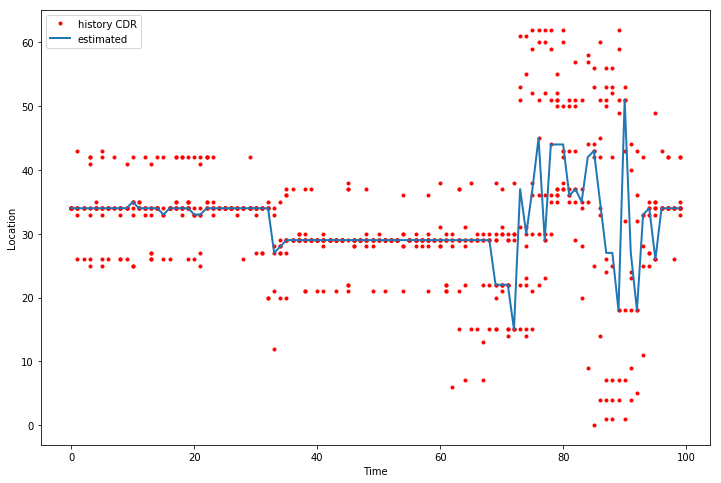

In [54]:
#example figure for history CDR idea
x = [i for i in range(100)]
fig1 = plt.figure(figsize = (12, 8))
for i in range(100):
    for j in range(10):
        if len(total_o[0][j][i]) > 0:
            if i == j == 0:
                plt.plot(x[i], total_o[0][j][i][0], 'r.', label = 'history CDR')
            else:
                plt.plot(x[i], total_o[0][j][i][0], 'r.')
plt.plot(x, total_trajectory, linewidth=2, label = 'estimated')
plt.xlabel('Time')
plt.ylabel('Location')
plt.legend()
plt.show()
fig1.savefig('history.jpg')

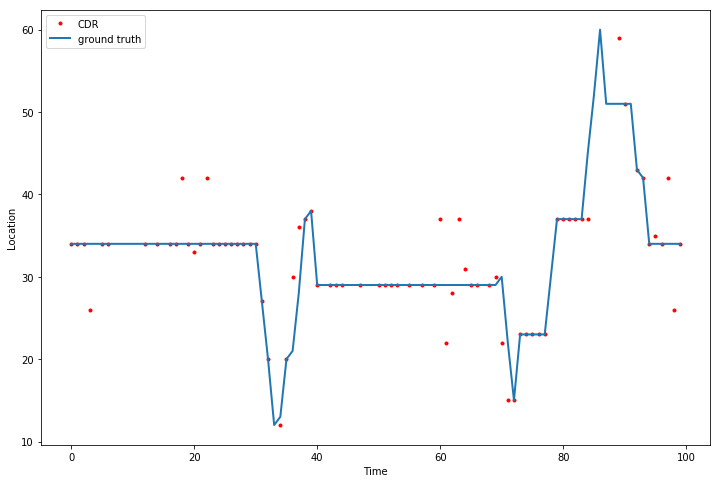

In [55]:
#example figure for actual CDR idea
fig2 = plt.figure(figsize = (12, 8))
for i in range(100):
    if len(temp_o_miss[0][i]) > 0:
        if i == 0:
            plt.plot(x[i], temp_o_miss[0][i][0], 'r.', label = 'CDR')
        else:
            plt.plot(x[i], temp_o_miss[0][i][0], 'r.')
plt.plot(x, temp_t, linewidth=2, label = 'ground truth')
plt.xlabel('Time')
plt.ylabel('Location')
plt.legend()
plt.show()
fig2.savefig('groundtruth.jpg')